# Figure 11

Same as Fig.10 but for local uncertainties of net CRH. For comparison, the mean values of net CRH uncertainty from Fig.10 are
superimposed as gray hatched bars. The mean uncertainties smaller than 0.05 k are not shown as they would not be visible in the plot. Note
the different x-axes in the panels

---
@ Behrooz Keshtgar, KIT 2024

## 1- load python packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import colorlegend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import warnings
warnings.filterwarnings("ignore")

For reference, print package versions to screen:

In [3]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.23.5
matplotlib: 3.3.0


## 2- Loading datasets

In [43]:
# Density profiles from previous analysis, figure 10
ds_rho = xr.open_dataset('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure10.nc')[['rho_mean_icon_dom01', 'rho_mean_icon_dom02', 'rho_mean_icon_dom03', 'rho_mean_icon_dom04']]
# post_processed MAD analysis at different resolution and for all LEM domains
ds_mad = xr.open_dataset('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/offline_radiation_calculation_output/lem_crhun_diag/crh_unc_domain_mean.nc')
# AMD analysis for all LEM domains, figure 10
ds_amd = xr.open_dataset('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure10.nc')

### For data publication

# creating a dataset and save for data publication
ds_out = xr.merge([ds_rho,ds_mad])
ds_out.attrs['description'] = 'Vertical profiles of MAD of CRH from different offline radiation calculation at different resolution for each LEM domain'
#ds_out.to_netcdf('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure11.nc')

In [8]:
ds_out = xr.open_dataset('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure11.nc')
# AMD analysis for all LEM domains, figure 10
ds_amd = xr.open_dataset('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure10.nc')

## 3- Calculating weighted vertical mean of mean absolute differences (MAD)

In [5]:
def weight_vertical_mean(ds, dom):
    """
    Calculate weighted vertical mean of MAD analysis in vertical intervals of 2 km.
    Input is a dataset containing MAD from different radiation calculations.
    """  
    rho = ds[f'rho_mean_icon_{dom}'].values
    dp = np.zeros((140))
    dp[1:-1] = (rho[2:] - rho[:-2]) 
    dp[0] = (rho[1] - rho[0]) 
    dp[-1] = (rho[-1] - rho[-2])
    dp = dp[::-1]
    
    mad_list = []
    # Define functions for repeated calculations
    def calculate_mad_vm(data, dp):
        return np.array([(np.sum(data[i:j] * dp[i:j]) / np.sum(dp[i:j])) for i, j in zip([0, 28, 45, 59, 71, 82], [28, 45, 59, 71, 82, 92])])

    for source in ['3d','hg','vo','ic']:
        # Impact of ice-optical param
        if dom == 'dom01' and source == 'ic':
            mad_list.extend([np.zeros(6), np.zeros(6), np.zeros(6)])
        else:
            # longwave
            mad_list.append(calculate_mad_vm(ds[f'{dom}_{source}_lw_error'][0].values,dp))
            # shortwave
            mad_list.append(calculate_mad_vm(ds[f'{dom}_{source}_sw_error'][0].values,dp))
            # net
            mad_list.append(calculate_mad_vm(ds[f'{dom}_{source}_nt_error'][0].values,dp))
        
        
    return mad_list

In [6]:
mad_dom01 = weight_vertical_mean(ds_out,'dom01')
mad_dom02 = weight_vertical_mean(ds_out,'dom02')
mad_dom03 = weight_vertical_mean(ds_out,'dom03')
mad_dom04 = weight_vertical_mean(ds_out,'dom04')

### 3-1 Calculating weighted vertical mean of absolute mean differences (AMD)

In [10]:
def absolute_mean_difference(ds, dom, rho):
    """
    Calculate AMD and weighted vertical mean in vertical intervals of 2 km.
    Input is a dataset containing time and spatial mean from different radiation calculations.
    """
    # thickness
    dp = np.zeros((140))
    dp[1:-1] = (rho[2:] - rho[:-2]) 
    dp[0] = (rho[1] - rho[0]) 
    dp[-1] = (rho[-1] - rho[-2])
    dp = dp[::-1]
    
    amd_list = []
    # Define functions for repeated calculations
    def calculate_amd_vm(data, dp):
        return np.array([(np.sum(data[i:j] * dp[i:j]) / np.sum(dp[i:j])) for i, j in zip([0, 28, 45, 59, 71, 82], [28, 45, 59, 71, 82, 92])])

    def calculate_and_append_amd_vm(prefix1, prefix2, ds):
        if prefix1 == 'smean_mystic':
            lw_amd = np.abs((ds[f'lwcrh_{prefix1}_{dom}'].mean('time') - ds[f'lwcrh_{prefix2}_{dom}'].mean('time')).values)
            sw_amd = np.abs((ds[f'swcrh_{prefix1}_{dom}'].mean('time') - ds[f'swcrh_{prefix2}_{dom}'].mean('time')).values)
            
            net1 = ds[f'lwcrh_{prefix1}_{dom}'].mean('time') + ds[f'swcrh_{prefix1}_{dom}'].mean('time')
            net2 = ds[f'lwcrh_{prefix2}_{dom}'].mean('time') + ds[f'swcrh_{prefix2}_{dom}'].mean('time')
            nt_amd = np.abs((net1 - net2).values)
            
        else:
            lw_amd = np.abs((ds[f'lwcrh_{prefix1}_{dom}'] - ds[f'lwcrh_{prefix2}_{dom}']).values)
            sw_amd = np.abs((ds[f'swcrh_{prefix1}_{dom}'] - ds[f'swcrh_{prefix2}_{dom}']).values)
            
            net1 = ds[f'lwcrh_{prefix1}_{dom}'] + ds[f'swcrh_{prefix1}_{dom}']
            net2 = ds[f'lwcrh_{prefix2}_{dom}'] + ds[f'swcrh_{prefix2}_{dom}']
            nt_amd = np.abs((net1 - net2).values)
        
        lw_amd_vm = calculate_amd_vm(lw_amd, dp)
        sw_amd_vm = calculate_amd_vm(sw_amd, dp)
        nt_amd_vm = calculate_amd_vm(nt_amd, dp)
    
        amd_list.append(lw_amd_vm)
        amd_list.append(sw_amd_vm)
        amd_list.append(nt_amd_vm)

    # 3D cloud radiative effects
    calculate_and_append_amd_vm('smean_mystic', 'smean_mystic_ica', ds)

    # Impact of cloud horizontal heterogeneity
    calculate_and_append_amd_vm('mean_nwp', 'mean_lem', ds)

    # Impact of cloud horizontal heterogeneity and cloud vertical overlap
    calculate_and_append_amd_vm('mean_nwpfr', 'mean_lem', ds)

    # Impact of ice-optical param
    if dom == 'dom01':
        amd_list.extend([np.zeros(6), np.zeros(6), np.zeros(6)])
    else:
        calculate_and_append_amd_vm('mean_fu', 'mean_Baum_ghm', ds)

    return amd_list

In [32]:
amd_dom01 = absolute_mean_difference(ds_amd,'dom01',ds_amd['rho_mean_icon_dom01'].values)
amd_dom02 = absolute_mean_difference(ds_amd,'dom02',ds_amd['rho_mean_icon_dom02'].values)
amd_dom03 = absolute_mean_difference(ds_amd,'dom03',ds_amd['rho_mean_icon_dom03'].values)
amd_dom04 = absolute_mean_difference(ds_amd,'dom04',ds_amd['rho_mean_icon_dom04'].values)

## 4- Plot

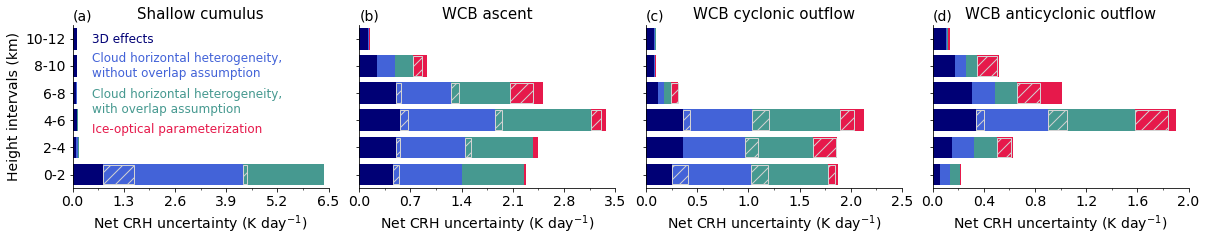

In [49]:
# height intervals
h1 = np.arange(0,6,1)
threshold = 0.05 # the threshold value to mask data

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 3)) 
i = 0

for ax in axes.flat:
    ax.tick_params(labelsize=14)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    
        
    ############################################################
    ####### Net ################################################
    ############################################################
    if i == 0:
        
        ax.barh(h1, mad_dom01[2], color='#000075', label='3D effetcs')
        ax.barh(h1, mad_dom01[5], color='#4363d8', left=mad_dom01[2], label='Horizontal heterogeneity')
        ax.barh(h1, mad_dom01[8], color='#469990', left=mad_dom01[2]+mad_dom01[5], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, mad_dom01[11], color='#e6194B', left=mad_dom01[2]+mad_dom01[5]+mad_dom01[8], label='Ice-optical parameterization')
        
        # Apply a mask
        masked_amd_dom01_2 = np.where(amd_dom01[2] < threshold, np.nan, amd_dom01[2])
        ax.barh(h1, masked_amd_dom01_2, edgecolor='lightgray', label='3D effects', fill=False, hatch="//", linewidth=1,
                height=0.725)
        
        masked_amd_dom01_5 = np.where(amd_dom01[5] < threshold, np.nan, amd_dom01[5])
        ax.barh(h1, masked_amd_dom01_5, edgecolor='lightgray', left=mad_dom01[2], label='Horizontal heterogeneity',
                fill=False, hatch="//", linewidth=1, height=0.725)

        masked_amd_dom01_8 = np.where(amd_dom01[8] < threshold, np.nan, amd_dom01[8])
        ax.barh(h1, masked_amd_dom01_8, edgecolor='lightgray', left=mad_dom01[2] + mad_dom01[5],
                label='Horizontal heterogeneity', fill=False, hatch="//", linewidth=1, height=0.725)

        #ax.barh(h1, amd_dom01[2], edgecolor='lightgray', label='3D effetcs',fill = False, hatch="//",linewidth=1,height=0.725)
        #ax.barh(h1, amd_dom01[5], edgecolor='lightgray', left=mad_dom01[2], label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.725)
        #ax.barh(h1, amd_dom01[8], edgecolor='lightgray', left=mad_dom01[2]+mad_dom01[5], label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.725)
    
    
        ax.set_title('Shallow cumulus', fontsize=15)
        ax.set_ylabel('Height intervals (km)', fontsize=14)
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        
        ax.set_xlim([0.,6.5])
        ax.spines['bottom'].set_bounds(0,6.5)
        ax.set_xticks(np.linspace(0,6.5,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.set_xlabel('Net CRH uncertainty (K day$^{-1}$)', fontsize=14)
        
        ax.text(0.0, 1.03, '(a)', transform=ax.transAxes, 
            size=14)
        
        ax.text(0.5, 5.2, '3D effects', color = '#000075', size=12, va="top")
        ax.text(0.5, 4.5, 'Cloud horizontal heterogeneity,\nwithout overlap assumption', color='#4363d8', size=12, va="top")
        ax.text(0.5, 3.2, 'Cloud horizontal heterogeneity,\nwith overlap assumption', color='#469990', size=12, va="top")
        ax.text(0.5, 1.9, 'Ice-optical parameterization', color='#e6194B', size=12, va="top")
        
    if i == 1:
        
        ax.barh(h1, mad_dom02[2], color='#000075', label='3D effetcs')
        ax.barh(h1, mad_dom02[5], color='#4363d8', left=mad_dom02[2], label='Horizontal heterogeneity')
        ax.barh(h1, mad_dom02[8], color='#469990', left=mad_dom02[2]+mad_dom02[5], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, mad_dom02[11], color='#e6194B', left=mad_dom02[2]+mad_dom02[5]+mad_dom02[8], label='Ice-optical parameterization')
        
        # Apply a mask
        masked_amd_dom02_2 = np.where(amd_dom02[2] < threshold, np.nan, amd_dom02[2])
        ax.barh(h1, masked_amd_dom02_2, edgecolor='lightgray', label='3D effects', fill=False, hatch="//", linewidth=1,
                height=0.725)
        
        masked_amd_dom02_5 = np.where(amd_dom02[5] < threshold, np.nan, amd_dom02[5])
        ax.barh(h1, masked_amd_dom02_5, edgecolor='lightgray', left=mad_dom02[2], label='Horizontal heterogeneity',
                fill=False, hatch="//", linewidth=1, height=0.725)

        masked_amd_dom02_8 = np.where(amd_dom02[8] < threshold, np.nan, amd_dom02[8])
        ax.barh(h1, masked_amd_dom02_8, edgecolor='lightgray', left=mad_dom02[2] + mad_dom02[5],
                label='Horizontal heterogeneity', fill=False, hatch="//", linewidth=1, height=0.725)
        
        masked_amd_dom02_11 = np.where(amd_dom02[11] < threshold, np.nan, amd_dom02[11])
        ax.barh(h1, masked_amd_dom02_11, edgecolor='lightgray', left=mad_dom02[2] + mad_dom02[5] + mad_dom02[8],
                label='Ice-optical parameterization', fill=False, hatch="//", linewidth=1, height=0.725)
        
        #ax.barh(h1, amd_dom02[2], edgecolor='lightgray', label='3D effetcs',fill = False, hatch="//",linewidth=1,height=0.725)
        #ax.barh(h1, amd_dom02[5], edgecolor='lightgray', left=mad_dom02[2], label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.725)
        #ax.barh(h1, amd_dom02[8], edgecolor='lightgray', left=mad_dom02[2]+mad_dom02[5], label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.725)
        #ax.barh(h1, amd_dom02[11], edgecolor='lightgray', left=mad_dom02[2]+mad_dom02[5]+mad_dom02[8], label='Ice-optical parameterization',fill = False, hatch="//",linewidth=1,height=0.725)
        
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,3.5])
        ax.spines['bottom'].set_bounds(0,3.5)
        ax.set_xticks(np.linspace(0,3.5,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.set_title('WCB ascent', fontsize=15)
        ax.set_xlabel('Net CRH uncertainty (K day$^{-1}$)', fontsize=14)
        
        ax.text(0.0, 1.03, '(b)', transform=ax.transAxes, 
            size=14)
        
    if i == 2:
        
        ax.barh(h1, mad_dom03[2], color='#000075', label='3D effetcs')
        ax.barh(h1, mad_dom03[5], color='#4363d8', left=mad_dom03[2], label='Horizontal heterogeneity')
        ax.barh(h1, mad_dom03[8], color='#469990', left=mad_dom03[2]+mad_dom03[5], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, mad_dom03[11], color='#e6194B', left=mad_dom03[2]+mad_dom03[5]+mad_dom03[8], label='Ice-optical parameterization')
        
        # Apply a mask
        masked_amd_dom03_2 = np.where(amd_dom03[2] < threshold, np.nan, amd_dom03[2])
        ax.barh(h1, masked_amd_dom03_2, edgecolor='lightgray', label='3D effects', fill=False, hatch="//", linewidth=1,
                height=0.725)
        
        masked_amd_dom03_5 = np.where(amd_dom03[5] < threshold, np.nan, amd_dom03[5])
        ax.barh(h1, masked_amd_dom03_5, edgecolor='lightgray', left=mad_dom03[2], label='Horizontal heterogeneity',
                fill=False, hatch="//", linewidth=1, height=0.725)

        masked_amd_dom03_8 = np.where(amd_dom03[8] < threshold, np.nan, amd_dom03[8])
        ax.barh(h1, masked_amd_dom03_8, edgecolor='lightgray', left=mad_dom03[2] + mad_dom03[5],
                label='Horizontal heterogeneity', fill=False, hatch="//", linewidth=1, height=0.725)
        
        masked_amd_dom03_11 = np.where(amd_dom03[11] < threshold, np.nan, amd_dom03[11])
        ax.barh(h1, masked_amd_dom03_11, edgecolor='lightgray', left=mad_dom03[2] + mad_dom03[5] + mad_dom03[8],
                label='Ice-optical parameterization', fill=False, hatch="//", linewidth=1, height=0.725)
        
        #ax.barh(h1, amd_dom03[2], edgecolor='lightgray', label='3D effetcs',fill = False, hatch="//",linewidth=1,height=0.725)
        #ax.barh(h1, amd_dom03[5], edgecolor='lightgray', left=mad_dom03[2], label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.725)
        #ax.barh(h1, amd_dom03[8], edgecolor='lightgray', left=mad_dom03[2]+mad_dom03[5], label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.725)
        #ax.barh(h1, amd_dom03[11], edgecolor='lightgray', left=mad_dom03[2]+mad_dom03[5]+mad_dom03[8], label='Ice-optical parameterization',fill = False, hatch="//",linewidth=1,height=0.725)
    
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,2.5])
        ax.spines['bottom'].set_bounds(0,2.5)
        ax.set_xticks(np.linspace(0,2.5,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.set_title('WCB cyclonic outflow', fontsize=15)
        ax.set_xlabel('Net CRH uncertainty (K day$^{-1}$)', fontsize=14)
        
        ax.text(0.0, 1.03, '(c)', transform=ax.transAxes, 
            size=14)
        
    if i == 3:
        
        ax.barh(h1, mad_dom04[2], color='#000075', label='3D effetcs')
        ax.barh(h1, mad_dom04[5], color='#4363d8', left=mad_dom04[2], label='Horizontal heterogeneity')
        ax.barh(h1, mad_dom04[8], color='#469990', left=mad_dom04[2]+mad_dom04[5], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, mad_dom04[11], color='#e6194B', left=mad_dom04[2]+mad_dom04[5]+mad_dom04[8], label='Ice-optical parameterization')
        
        # Apply a mask
        masked_amd_dom04_2 = np.where(amd_dom04[2] < threshold, np.nan, amd_dom04[2])
        ax.barh(h1, masked_amd_dom04_2, edgecolor='lightgray', label='3D effects', fill=False, hatch="//", linewidth=1,
                height=0.725)
        
        masked_amd_dom04_5 = np.where(amd_dom04[5] < threshold, np.nan, amd_dom04[5])
        ax.barh(h1, masked_amd_dom04_5, edgecolor='lightgray', left=mad_dom04[2], label='Horizontal heterogeneity',
                fill=False, hatch="//", linewidth=1, height=0.725)

        masked_amd_dom04_8 = np.where(amd_dom04[8] < threshold, np.nan, amd_dom04[8])
        ax.barh(h1, masked_amd_dom04_8, edgecolor='lightgray', left=mad_dom04[2] + mad_dom04[5],
                label='Horizontal heterogeneity', fill=False, hatch="//", linewidth=1, height=0.725)
        
        masked_amd_dom04_11 = np.where(amd_dom04[11] < threshold, np.nan, amd_dom04[11])
        ax.barh(h1, masked_amd_dom04_11, edgecolor='lightgray', left=mad_dom04[2] + mad_dom04[5] + mad_dom04[8],
                label='Ice-optical parameterization', fill=False, hatch="//", linewidth=1, height=0.725)
        
        #ax.barh(h1, amd_dom04[2], edgecolor='lightgray', label='3D effetcs',fill = False, hatch="//",linewidth=1,height=0.725)
        #ax.barh(h1, amd_dom04[5], edgecolor='lightgray', left=mad_dom04[2], label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.725)
        #ax.barh(h1, amd_dom04[8], edgecolor='lightgray', left=mad_dom04[2]+mad_dom04[5], label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.725)
        #ax.barh(h1, amd_dom04[11], edgecolor='lightgray', left=mad_dom04[2]+mad_dom04[5]+mad_dom04[8], label='Ice-optical parameterization',fill = False, hatch="//",linewidth=1,height=0.725)
        
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,2])
        ax.spines['bottom'].set_bounds(0,2)
        ax.set_xticks(np.linspace(0,2,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.set_title('WCB anticyclonic outflow', fontsize=15)
        ax.set_xlabel('Net CRH uncertainty (K day$^{-1}$)', fontsize=14)
        
        ax.text(0.0, 1.03, '(d)', transform=ax.transAxes, 
            size=14)    
     
    i = i + 1     

fig.subplots_adjust(wspace=0.12,hspace=0.55)

plt.savefig('figure11.pdf', bbox_inches = 'tight')
plt.savefig('figure11.png', bbox_inches = 'tight',dpi=300)